In [1]:
import torch
from pyqcu.ascend import dslash
from pyqcu.ascend.include import *
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 16, 16)
# latt_size = (16, 16, 16, 32)
# latt_size = (16, 16, 16, 16)
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 32, 64)
# latt_size = (4, 8, 8, 8)
# latt_size = (8, 8, 8, 4)
# latt_size = (16, 8, 8, 8)
latt_size = (8, 8, 8, 16)
# latt_size = (8, 8, 8, 8)
# latt_size = (4, 4, 4, 4)
# latt_size = (2, 2, 2, 2)
# mass = -3.5
# mass = -0.8
# mass = -0.5
# mass = 0.05
# mass = 0.0
mass = -0.05
# kappa = 0.4
# kappa = 0.125
# kappa = 0.5
kappa = 1 / (2 * mass + 8)
dtype = torch.complex128
# dtype = torch.complex64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# Initialize lattice gauge theory
wilson = dslash.wilson_mg(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
clover = dslash.clover(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
U = wilson.generate_gauge_field(sigma=0.1, seed=42)

wilson.check_su3(U)
clover_term = clover.make_clover(U=U)

b = torch.randn(4, 3, latt_size[3], latt_size[2], latt_size[1], latt_size[0],
                dtype=dtype, device=device)
verbose = True


    @@@@@@######QCU NOTES START######@@@@@@@
    Guide:
    0. Required: MPI(e.g. 4.1.2), CUDA(e.g. 12.4), CMAKE(e.g. 3.22.1), GCC(e.g. 11.4.0), HDF5-MPI(e.g. 1.10.7,'apt install libhdf5-mpi-dev && export HDF5_MPI="ON" && pip install --no-binary=h5py h5py').
    1. The libqcu.so was compiled when pyqcu setup in download_path/PyQCU/lib, please add this path to your LD_LIBRARY_PATH.
    2. The QCU(PyQCU) splite grid by x->y->z->t, lattice by x->y->z->t->p->d[x,y,z,t]->c->c or x->y->z->t->c->s(->p) and x->y->z->t->c->s->c->s(->p).
    3. The QUDA(PyQUDA) splite grid by t->z->y->x, lattice by c->c->x->y->z->t->p->d[x,y,z,t] or c->s->x->y->z->t(->p) and c->s->c->s->x->y->z->t(->p).
    4. The QCU input params in numpy array(dtype=np.int32), argv in  numpy array(dtype=np.float32 or float64) array, set_ptrs in numpy array(dtype=np.int64), other in cupy array(dtype=cp.complex64 or complex128).
    5. The smallest lattice size is (wilson:x=4,y=4,z=4,t=4;clover:x=8,y=8,z=8,t=8) that QCU support

In [2]:
hopping_plus_list = []
hopping_minus_list = []
for ward in range(4):
    hopping_plus_list.append(wilson.give_hopping_plus(ward=ward, U=U))
    hopping_minus_list.append(wilson.give_hopping_minus(ward=ward, U=U))
Ab = wilson.give_wilson(src=b, U=U, with_I=False)
_Ab = torch.zeros_like(b)
for ward in range(4):
    _Ab += wilson.give_wilson_plus(ward=ward, src=b.reshape(
        [12]+list(U.shape[-4:])), hopping=hopping_plus_list[ward]).reshape([4, 3]+list(U.shape[-4:]))
    _Ab += wilson.give_wilson_minus(ward=ward, src=b.reshape(
        [12]+list(U.shape[-4:])), hopping=hopping_minus_list[ward]).reshape([4, 3]+list(U.shape[-4:]))
print(torch.norm(Ab-_Ab).item()/torch.norm(Ab).item())

2.1685346641519847e-16


In [3]:
from pyqcu.ascend import inverse
mg = inverse.mg(b=b, wilson=wilson, U=U,
                clover=clover, clover_term=clover.add_I(clover_term=clover_term), verbose=verbose, max_iter=100, max_levels=2)

self.dof_list:[12, 12, 12, 12, 24, 24, 24, 24, 48, 48, 24, 8, 8, 8, 4, 12, 12, 12, 8, 4, 2, 4, 4, 24, 12, 12, 12, 4, 4, 4, 4, 4]
Building grid list:
  Level 0: 8x8x8x16
  Level 1: 4x4x4x8
self.grid_list:[[16, 8, 8, 8], [8, 4, 4, 4]]
Norm of b:351.42692512022506
Norm of r:497.7914331736727
Norm of x0:313.90127462815883
BICGSTAB-Iteration 0: Residual = 8.572722e+01, Time = 0.009114 s
BICGSTAB-Iteration 1: Residual = 2.828312e+01, Time = 0.007320 s
BICGSTAB-Iteration 2: Residual = 5.511619e+01, Time = 0.006519 s
BICGSTAB-Iteration 3: Residual = 9.521165e+00, Time = 0.006734 s
BICGSTAB-Iteration 4: Residual = 8.061327e+00, Time = 0.006567 s
BICGSTAB-Iteration 5: Residual = 4.194663e+00, Time = 0.006691 s
BICGSTAB-Iteration 6: Residual = 2.892130e+00, Time = 0.006767 s
BICGSTAB-Iteration 7: Residual = 2.242247e+01, Time = 0.006594 s
BICGSTAB-Iteration 8: Residual = 3.075912e+00, Time = 0.006678 s
BICGSTAB-Iteration 9: Residual = 2.622588e+00, Time = 0.007188 s
BICGSTAB-Iteration 10: Residua

In [4]:
def matvec(src: torch.Tensor, U: torch.Tensor = U, clover_term: torch.Tensor = clover_term) -> torch.Tensor:
    return wilson.give_wilson(src, U)+clover.give_clover(clover_term=clover_term, src=src)


def _matvec(src: torch.Tensor) -> torch.Tensor:
    return mg.op_list[0].matvec(src=src)

In [5]:
%%time
%time Ab = matvec(b)
%time _Ab = _matvec(b)
print(torch.norm(U).item())
print(torch.norm(clover_term).item())
print(torch.norm(Ab).item())
print(torch.norm(_Ab).item())
print(torch.norm(Ab-_Ab).item()/torch.norm(_Ab).item())

CPU times: user 3.22 ms, sys: 229 μs, total: 3.45 ms
Wall time: 2.82 ms
CPU times: user 2.47 ms, sys: 0 ns, total: 2.47 ms
Wall time: 2.07 ms
313.53468707624677
15.064980658884766
351.530776679681
351.530776679681
1.741567544887391e-16
CPU times: user 32.9 ms, sys: 238 μs, total: 33.1 ms
Wall time: 31.8 ms


In [6]:
%time Ab = matvec(b)
%time _Ab = _matvec(b)

CPU times: user 6 ms, sys: 430 μs, total: 6.43 ms
Wall time: 5.45 ms
CPU times: user 3.37 ms, sys: 0 ns, total: 3.37 ms
Wall time: 3.23 ms


In [7]:
b0 = mg.b_list[0]
b1 = inverse.restrict(
    local_ortho_null_vecs=mg.lonv_list[0], fine_vec=b0)
_b0 = inverse.prolong(local_ortho_null_vecs=mg.lonv_list[0], coarse_vec=b1)
_b1 = inverse.restrict(
    local_ortho_null_vecs=mg.lonv_list[0], fine_vec=_b0)
print(_b1.flatten()[:100]/b1.flatten()[:100])

restrict:shape,coarse_dof:(torch.Size([12, 12, 8, 2, 4, 2, 4, 2, 4, 2]), 12)
EeTtZzYyXx,eTtZzYyXx->ETZYX
prolong:shape,fine_dof:(torch.Size([12, 12, 8, 2, 4, 2, 4, 2, 4, 2]), 12)
EeTtZzYyXx,ETZYX->eTtZzYyXx
restrict:shape,coarse_dof:(torch.Size([12, 12, 8, 2, 4, 2, 4, 2, 4, 2]), 12)
EeTtZzYyXx,eTtZzYyXx->ETZYX
tensor([1.0000+2.3324e-16j, 1.0000+5.6011e-20j, 1.0000-2.4050e-16j,
        1.0000-3.2583e-17j, 1.0000+2.5107e-17j, 1.0000+3.9546e-17j,
        1.0000-1.5070e-18j, 1.0000-2.4375e-17j, 1.0000-6.7345e-17j,
        1.0000-4.0848e-17j, 1.0000+6.7952e-17j, 1.0000+2.2974e-16j,
        1.0000-5.0929e-17j, 1.0000+6.9252e-17j, 1.0000+1.6120e-16j,
        1.0000-1.3255e-16j, 1.0000-6.7300e-16j, 1.0000-2.7254e-17j,
        1.0000+1.6146e-16j, 1.0000+1.1071e-16j, 1.0000+9.0822e-17j,
        1.0000-2.6404e-16j, 1.0000+1.7165e-17j, 1.0000+1.1133e-16j,
        1.0000+8.9761e-17j, 1.0000-4.6763e-16j, 1.0000+7.2636e-17j,
        1.0000+1.0020e-16j, 1.0000+1.3252e-16j, 1.0000-2.5731e-17j,
        

In [8]:
# _x = inverse.cg(b=b, matvec=matvec, verbose=verbose)
_x = inverse.bicgstab(b=b, matvec=_matvec, verbose=verbose)
# _x = inverse.bicgstab(b=b, matvec=mg.op_list[0].matvec, verbose=verbose)

Norm of b:313.60298027911824
Norm of r:470.3868169963199
Norm of x0:313.3230180364879
BICGSTAB-Iteration 0: Residual = 1.018867e+02, Time = 0.006652 s
BICGSTAB-Iteration 1: Residual = 4.362586e+01, Time = 0.006685 s
BICGSTAB-Iteration 2: Residual = 4.426075e+01, Time = 0.006620 s
BICGSTAB-Iteration 3: Residual = 2.979295e+01, Time = 0.006805 s
BICGSTAB-Iteration 4: Residual = 1.802750e+01, Time = 0.006963 s
BICGSTAB-Iteration 5: Residual = 1.361699e+01, Time = 0.007102 s
BICGSTAB-Iteration 6: Residual = 1.176492e+01, Time = 0.006865 s
BICGSTAB-Iteration 7: Residual = 1.194446e+01, Time = 0.007287 s
BICGSTAB-Iteration 8: Residual = 1.481551e+01, Time = 0.006645 s
BICGSTAB-Iteration 9: Residual = 2.079181e+01, Time = 0.006529 s
BICGSTAB-Iteration 10: Residual = 1.669071e+01, Time = 0.006864 s
BICGSTAB-Iteration 11: Residual = 1.225495e+01, Time = 0.007993 s
BICGSTAB-Iteration 12: Residual = 1.344949e+01, Time = 0.006663 s
BICGSTAB-Iteration 13: Residual = 1.034000e+01, Time = 0.006768 s


MG-0:Norm of b:313.60298027911824
MG-0:Norm of r:470.75092104681914
MG-0:Norm of x0:313.24444587632877
B-MG-0-BICGSTAB-Iteration 0: Residual = 1.022710e+02
restrict:shape,coarse_dof:(torch.Size([12, 12, 8, 2, 4, 2, 4, 2, 4, 2]), 12)
EeTtZzYyXx,eTtZzYyXx->ETZYX
MG-1:Norm of b:46.067885183088535
MG-1:Norm of r:274.1187340123551
MG-1:Norm of x0:77.42364113396427
B-MG-1-BICGSTAB-Iteration 0: Residual = 1.650325e+00
F-MG-1-BICGSTAB-Iteration 0: Residual = 1.650325e+00, Time = 0.002692 s
B-MG-1-BICGSTAB-Iteration 1: Residual = 1.684897e-02
F-MG-1-BICGSTAB-Iteration 1: Residual = 1.684897e-02, Time = 0.002929 s
Converged at iteration 1 with residual 1.684897e-02

Performance Statistics:
Total iterations: 2
Total time: 0.005646 seconds
Average time per iteration: 0.002810 s
Final residual: 1.68e-02
prolong:shape,fine_dof:(torch.Size([12, 12, 8, 2, 4, 2, 4, 2, 4, 2]), 12)
EeTtZzYyXx,ETZYX->eTtZzYyXx
F-MG-0-BICGSTAB-Iteration 0: Residual = 1.004299e+02, Time = 0.019416 s
B-MG-0-BICGSTAB-Iteratio

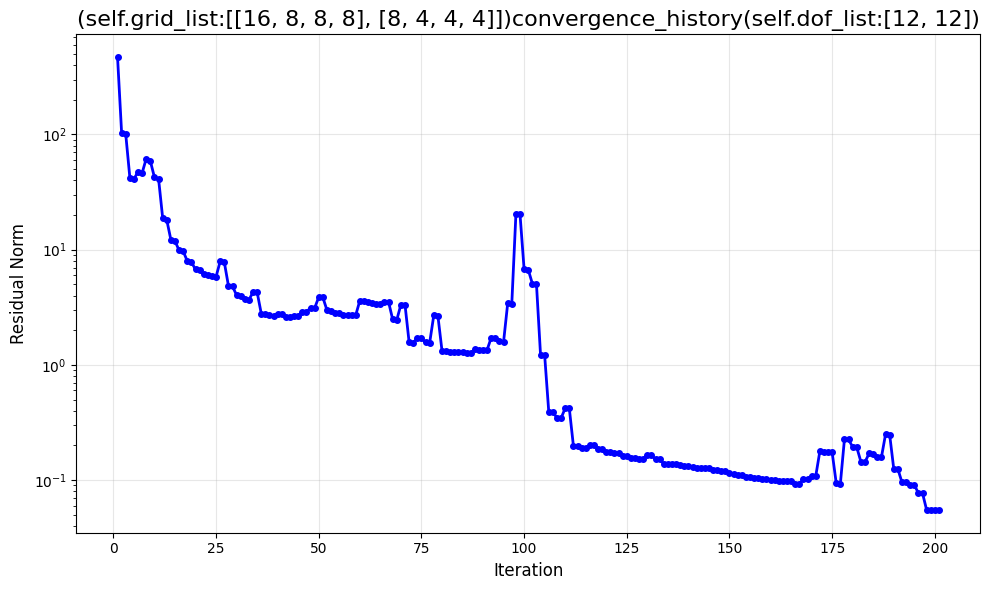

In [9]:
x = mg.solve()
mg.plot()

In [10]:
mg.lonv_list[0].shape

torch.Size([12, 12, 8, 2, 4, 2, 4, 2, 4, 2])

In [11]:
(mg.b_list[0]-mg.op_list[0].matvec(x.reshape([12]+list(x.shape[-4:])))).flatten()[:100]

tensor([ 5.7014e-05+9.1267e-05j,  1.0476e-05+9.6629e-05j,  6.8364e-05+1.2266e-04j,
         3.1224e-05+1.2147e-04j,  9.6495e-05+1.2921e-04j,  1.2692e-05+1.2336e-04j,
         1.0674e-04+1.2410e-04j,  7.7510e-06+8.6363e-05j,  1.0783e-05+8.2232e-05j,
         6.9171e-05+1.4879e-04j,  2.6460e-05+1.1256e-04j,  9.4804e-05+1.0972e-04j,
         1.8737e-05+1.0874e-04j,  3.5503e-05+9.9360e-05j,  3.8969e-05+1.1248e-04j,
         9.5935e-05+1.3803e-04j,  3.6054e-05+1.1302e-04j,  1.7396e-05+7.9584e-05j,
         5.1055e-05+1.2389e-04j, -4.0966e-06+9.0809e-05j,  6.5868e-05+1.1270e-04j,
        -1.6547e-05+1.3951e-04j,  8.9859e-05+1.0030e-04j,  1.5618e-05+1.0016e-04j,
        -7.4523e-06+1.0091e-04j,  5.2779e-05+1.2243e-04j, -3.0157e-05+8.0378e-05j,
         3.7121e-05+8.3022e-05j,  2.3067e-05+1.0722e-04j,  6.1264e-05+1.2454e-04j,
         2.1898e-05+1.0632e-04j,  6.6130e-05+9.0167e-05j,  3.9965e-05+1.4490e-04j,
         2.1061e-05+1.0168e-04j,  6.2995e-05+1.2450e-04j,  1.0575e-05+1.0453e-04j,
    

In [12]:
print(torch.norm(x-_x).item()/torch.norm(_x).item())

0.01340050863444129


In [13]:
mg.num_levels

2

In [14]:
index = 1
null_vecs = mg.nv_list[index]
matvec = mg.op_list[index].matvec
for i in range(null_vecs.shape[0]):
    print(
        f"(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:{(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]}")

IndexError: list index out of range

In [ ]:
mg.nv_list[-1].flatten()[:100]

In [ ]:
_null_vec = torch.randn_like(null_vecs[0])*10000
print(torch.norm(matvec(_null_vec)))
print(matvec(_null_vec).flatten()[:20])
_null_vec -= inverse.bicgstab(b=matvec(_null_vec), matvec=matvec, tol=5e-5)
print(torch.norm(_null_vec))
print(_null_vec.flatten()[:20])
_null_vec/=torch.norm(_null_vec).item()
print(
    f"(matvec(_null_vec)/_null_vec).flatten()[:10]:{(matvec(_null_vec)/_null_vec).flatten()[:10]}")

In [ ]:
_b = torch.randn_like(null_vecs[0])
_x = inverse.bicgstab(b=_b, matvec=matvec, tol=1e-8)
print((_b-matvec(_x)).flatten()[:100])
print(torch.norm(_b))
print(torch.norm(_x))

In [ ]:
_null_vec.flatten()[:100]